## Task 1
### Question
Briefly discuss why it is more difficult to find a good classifier on such a dataset than on one where, for example, 5,000 claims are fraudulent, and 5,000 are not. In particular, consider what happens when undetected fraudulent claims are very costly to the insurance company.

### Answer
When the dataset in highly unbalanced, like what in the car-insurance case, the machine learning algorithm can predict well in the majority class and predict poorly in minority class. Since most of machine learning algorithm always pursue to decrease error rate, thus they tend to predict the all the label to majority class one. In our scenario, the algorithm tends to predict all the claims non-fraudulent. However, the wrong prediction will increase the False-negative rate, which will increase the cost of fraudulent claims.
Another issue related to the scarce minority data is that we might miss some key combination of variables that has high probability to be fraudulent.

Check how much NaN values in each column when the claim is frandulent.
We can find when the claim is frandulent, most of the numerical variables are not missing, which means we could directly drop them.

In [92]:
# TODO missing data 
# TODO draw the graph compare Fraud case
# TODO ANOVA
# TODO Timestamp
# TODO check the range of all variables and drop unreasonable numbers
# TODO split first and scale with smote code
# TODO check scale first or smote first
# TODO validation loss and trainning loss
# TODO the batch size is 32
# TODO train test validation
# TODO check the roc curve
# TODO hidden layer number
# TODO smote oversampling issue

## Task 2
### Question
Load the dataset "Insurance_claims.csv" and clean it as appropriate for use with machine learning algorithms. A description of the features can be found at the end of this document.

### Principle
1. Since the dataset is highly unbalanced, and the fraudulent dataset is very scarce, we don't want to drop the data label with 'fradulent'.
2. When the variables is categorical varibles, we tend to keep the Nah value as a classificaiton value rather than drop it.
3. When the variables is numerical variables, we will check how many NaN values is related to the fraudulent case. If few of them, we will drop the variable. Otherwise, we will find a way to fill in the NaN values.

### Proprocess procedure
1. load data and select useful columns
2. drop duplicates
3. drop unreasonable rows
4. deal with nan data
    - deal with the categorical nan data
    - deal with the numerical nan data
5. deal with date data
6. get an insight of the distribution of dataset
    - check whether there is a signicicant distribution difference in every column in fraud data and non-fraud data
7. clean features
    - dummy
    - outlier # TODO
8. split data and scale
9.  show the data structure after preprocess



In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns',None)

## 2.1 Load data and select useful columns
We are going to use the following features to predict the fraud cases:
1. PolicyholderOccupation
2. LossDate
3. FirstPolicySubscriptionDate
4. ClainType
5. ClaimInvolvedCovers
6. DamageImportance
7. FirstPartyVehicleType
8. ConnectionBetweenParties
9. PolicyWasSubscribedOnInternet
10. NumberOfPoliciesOfPolicyholder
11. FpVehicleAgeMonths
12. EasinessToStage
13. ClaimWihoutIdentifiedThirdParty
14. ClaimAmount
15. LossHour
16. PolicyHolderAge
17. NumberOfBodilyInjuries
18. FirstPartyLiability
19. LossAndHolderPostCodeSame

And we also need label:
1. Fraud

In [94]:
# read data and get a brief idea of the data
df = pd.read_csv('./materials/Insurance_claims.csv')
# get useful features that needed in the machine learning model
# TODO using nlp to insurer notes data
needed_columns = [ 'PolicyholderOccupation',
       'LossDate', 'FirstPolicySubscriptionDate', 'ClaimCause',
       'ClaimInvolvedCovers', 'DamageImportance', 'FirstPartyVehicleType',
       'ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet',
       'NumberOfPoliciesOfPolicyholder', 'FpVehicleAgeMonths',
       'EasinessToStage', 'ClaimWihoutIdentifiedThirdParty', 'ClaimAmount',
       'LossHour', 'PolicyHolderAge', 'NumberOfBodilyInjuries',
       'FirstPartyLiability', 'LossAndHolderPostCodeSame','Fraud']
df = df[needed_columns]

# show the first 5 rows, get some idea of the data structure
print(f'Data sample:')
print(df.head(5)) #TODO use sentiment analysis 
print('-----------------------------------------------------')

# get the columns name
print('Data Columns:')
print(str(df.columns))
print('-----------------------------------------------------')

# get some basic information about the data, and we found that the min number 
# of FpVehicleAgeMonths is less than 0, which does't make sense. We are going 
# to detect whether these rows are fraud cases or not. If they are all non-fraud,
# we can drop the rows with negative FpVehicleAgeMonths value. Otherwise, we will 
# create a new feature that record these abnormal rows since these unreasonable 
# values might be evidence of fraud cases.
print('Data description:')
print(df.describe())
print('-----------------------------------------------------')

# check whether there are any duplicated rows and we found there are 8 duplicated rows,
# which we are going to drop.
print('Data duplicated rows:')
print(df.duplicated().sum())
print('-----------------------------------------------------')

Data sample:
  PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
0           CivilServant  02.01.19                    18.06.18   
1                 Worker  02.01.19                    29.06.17   
2                 Worker  02.01.19                    05.02.17   
3           CivilServant  02.01.19                    21.01.17   
4                 Farmer  02.01.19                    13.01.18   

                         ClaimCause  \
0               CollisionWithAnimal   
1                     LossOfControl   
2  AccidentWithIdentifiedThirdParty   
3  AccidentWithIdentifiedThirdParty   
4  AccidentWithIdentifiedThirdParty   

                               ClaimInvolvedCovers DamageImportance  \
0                     MaterialDamages ActLiability              NaN   
1                     MaterialDamages ActLiability              NaN   
2                     MaterialDamages ActLiability              NaN   
3  MaterialDamages ActLiability ReplacementVehicle              NaN   


## 2.2 Drop the duplicated rows

In [95]:
print('The shape of the data before dropping duplicated rows:')
df_shape_before_drop = df.shape
print(df.shape)
print('-----------------------------------------------------')

# drop the duplicated rows
df.drop_duplicates(inplace=True)

print('The shape of the data after dropping duplicated rows:')
df_shape_after_drop = df.shape
print(df.shape)
print('-----------------------------------------------------')

print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')



The shape of the data before dropping duplicated rows:
(11530, 20)
-----------------------------------------------------
The shape of the data after dropping duplicated rows:
(11516, 20)
-----------------------------------------------------
The number of rows that are dropped: 14


## 2.3 Drop unreasonable values


In [96]:
# check whether unreasonable rows contain fraud cases
df_unreasonable_rows = df[df['FpVehicleAgeMonths'] < 0]
df_shape_before_drop = df_unreasonable_rows.shape
print(df_unreasonable_rows)
print('-----------------------------------------------------')
# we can find that these three rows are not fraud cases. 
# Since we have enough non-fraud data, we can drop these rows.
df_shape_before_drop = df.shape
df.drop(df_unreasonable_rows.index, inplace=True)
df_shape_after_drop = df.shape

print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')

     PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
8019                Retired  24.06.20                    22.10.19   
8446                Retired  21.07.20                    26.02.20   
8529                Retired  17.07.20                    26.02.20   

            ClaimCause           ClaimInvolvedCovers DamageImportance  \
8019     LossOfControl  MaterialDamages ActLiability              NaN   
8446     LossOfControl  MaterialDamages ActLiability              NaN   
8529  WindscreenDamage                    Windscreen              NaN   

     FirstPartyVehicleType ConnectionBetweenParties  \
8019                   Car                      NaN   
8446                   Car                      NaN   
8529                   Car                      NaN   

      PolicyWasSubscribedOnInternet  NumberOfPoliciesOfPolicyholder  \
8019                              0                               2   
8446                              0                               4

## 2.4 Deal with nan data
Check how much NaN values in each column.

We can find that except for 'FirstPartyVehicleNumber', 'ThirdPartyVehicleNumber', 'InsurerNotes', which we might not use in our models, most the NaN values are concentrated in the 'PolicyholderOccupation', 'ClaimCause',etc which are mainly categorical variables. In this case, we could turn these NaN values into a category value in order to take account the influence of missing variables, no mather what reason they are missing.

In terms of the numeric variables, we will furtherly check how many of them are missing when the claim is fraudulent or not. 

In [97]:
# Check how much NaN values in each column.
print(f'Number of NaN values in each column:') 
print(df.isnull().sum())

Number of NaN values in each column:
PolicyholderOccupation               340
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           191
ClaimInvolvedCovers                  189
DamageImportance                   10775
FirstPartyVehicleType                 12
ConnectionBetweenParties           11415
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    12
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              94
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiability                    0
LossAndHolderPostCodeSame              0
Fraud                                  0
dtype: int64


We can find that in the Fraud case, there are a lot of data missing in categorical columns, but few in numerical columns.

Thus, we can set NaN as a category of categorical data and generate dummy variables. And we can drop the rows that contains NaN values in numerical columns.

In [98]:
# Check the number of missing data when Frand is True
df_fraud = df[df["Fraud"]==1]
print(f'Number of NaN values in each column when Frand is True:')
print(df_fraud.isnull().sum())

Number of NaN values in each column when Frand is True:
PolicyholderOccupation               4
LossDate                             0
FirstPolicySubscriptionDate          0
ClaimCause                           0
ClaimInvolvedCovers                  0
DamageImportance                    96
FirstPartyVehicleType                2
ConnectionBetweenParties           102
PolicyWasSubscribedOnInternet        0
NumberOfPoliciesOfPolicyholder       0
FpVehicleAgeMonths                   2
EasinessToStage                      0
ClaimWihoutIdentifiedThirdParty      0
ClaimAmount                          0
LossHour                             1
PolicyHolderAge                      0
NumberOfBodilyInjuries               0
FirstPartyLiability                  0
LossAndHolderPostCodeSame            0
Fraud                                0
dtype: int64


In [99]:
df_non_frand = df[df["Fraud"]==0]
print(f'Number of NaN values in each column when Frand is False:')
print(df_non_frand.isnull().sum())

Number of NaN values in each column when Frand is False:
PolicyholderOccupation               336
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           191
ClaimInvolvedCovers                  189
DamageImportance                   10679
FirstPartyVehicleType                 10
ConnectionBetweenParties           11313
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    10
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              93
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiability                    0
LossAndHolderPostCodeSame              0
Fraud                                  0
dtype: int64


Fill the missing data in categorical columns with string NaN and make it a category

In [100]:
dummy_columns = ['PolicyholderOccupation', 'ClaimCause','ClaimInvolvedCovers', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']
df[dummy_columns] = df[dummy_columns].fillna('NaN')

Drop the missing data in numerical columns

In [101]:
df_shape_before_drop = df.shape
df_fraud_shape_before_drop = df[df["Fraud"]==1].shape
df.dropna(subset=["LossHour","PolicyHolderAge","FpVehicleAgeMonths"],inplace=True)
df_shape_after_drop = df.shape
df_fraud_shape_after_drop = df[df["Fraud"]==1].shape
print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')
print(f'The number of rows that are dropped when Frand is True: {df_fraud_shape_before_drop[0]-df_fraud_shape_after_drop[0]}')

The number of rows that are dropped: 142
The number of rows that are dropped when Frand is True: 3


After these steps, we don't have any missing data.

In [102]:
print('The number of NaN values in each column:')
df.isna().sum()
print('-----------------------------------------------------')

print('The shape of final datasets:')
print(df.shape)
print('-----------------------------------------------------')

print("Data sample:")
print(df.head(5))
print('-----------------------------------------------------')

The number of NaN values in each column:
-----------------------------------------------------
The shape of final datasets:
(11371, 20)
-----------------------------------------------------
Data sample:
  PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
0           CivilServant  02.01.19                    18.06.18   
1                 Worker  02.01.19                    29.06.17   
2                 Worker  02.01.19                    05.02.17   
3           CivilServant  02.01.19                    21.01.17   
4                 Farmer  02.01.19                    13.01.18   

                         ClaimCause  \
0               CollisionWithAnimal   
1                     LossOfControl   
2  AccidentWithIdentifiedThirdParty   
3  AccidentWithIdentifiedThirdParty   
4  AccidentWithIdentifiedThirdParty   

                               ClaimInvolvedCovers DamageImportance  \
0                     MaterialDamages ActLiability              NaN   
1                     M

## 2.5 Deal with date data
We tend to consider the date data as important features. Because we consider that in different time period, people might have different tendency to defraud. And this argument is supported by Pascal Blanque(2002), who asserted that the economic crisis is an important reason for the defraud.

However, our date data is datetime format, which cannot be used in machine learning model. In hence, we will convert the date data into timestamp.

In [103]:
# turn the date into timestamp
df['LossDate'] = df['LossDate'].apply(lambda x:datetime.datetime.strptime(x,'%d.%M.%y').timestamp())
df['FirstPolicySubscriptionDate'] = df['FirstPolicySubscriptionDate'].apply(lambda x:datetime.datetime.strptime(x,'%d.%M.%y').timestamp())


## 2.6 Get an insight of the distribution of dataset

In [104]:
# get the datasets that are fraud cases and non-fraud cases
df_fraud = df[df['Fraud'] == 1]
df_non_fraud = df[df['Fraud'] == 0]

In [105]:
# get the mean of both datasets
print('The mean of fraud datasets:')
print('-----------------------------------------------------')
df_fraud_mean = df_fraud.mean()
print(df_fraud_mean)
print('-----------------------------------------------------')

print('The mean of non-fraud datasets:')
print('-----------------------------------------------------')
df_non_fraud_mean = df_non_fraud.mean()
print(df_non_fraud_mean)
print('-----------------------------------------------------')

The mean of fraud datasets:
-----------------------------------------------------
LossDate                           1.557971e+09
FirstPolicySubscriptionDate        1.546519e+09
PolicyWasSubscribedOnInternet      2.857143e-01
NumberOfPoliciesOfPolicyholder     1.625000e+00
FpVehicleAgeMonths                 1.177143e+02
EasinessToStage                    3.464286e-01
ClaimWihoutIdentifiedThirdParty    5.625000e-01
ClaimAmount                        3.647878e+03
LossHour                           1.292857e+01
PolicyHolderAge                    4.104464e+01
NumberOfBodilyInjuries             3.571429e-02
FirstPartyLiability                4.910714e-01
LossAndHolderPostCodeSame          6.160714e-01
Fraud                              1.000000e+00
dtype: float64
-----------------------------------------------------
The mean of non-fraud datasets:
-----------------------------------------------------
LossDate                           1.564733e+09
FirstPolicySubscriptionDate        1.523620

/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_80655/1158699191.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fraud_mean = df_fraud.mean()
/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_80655/1158699191.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_non_fraud_mean = df_non_fraud.mean()


The distribution numerical data of fraud datasets:


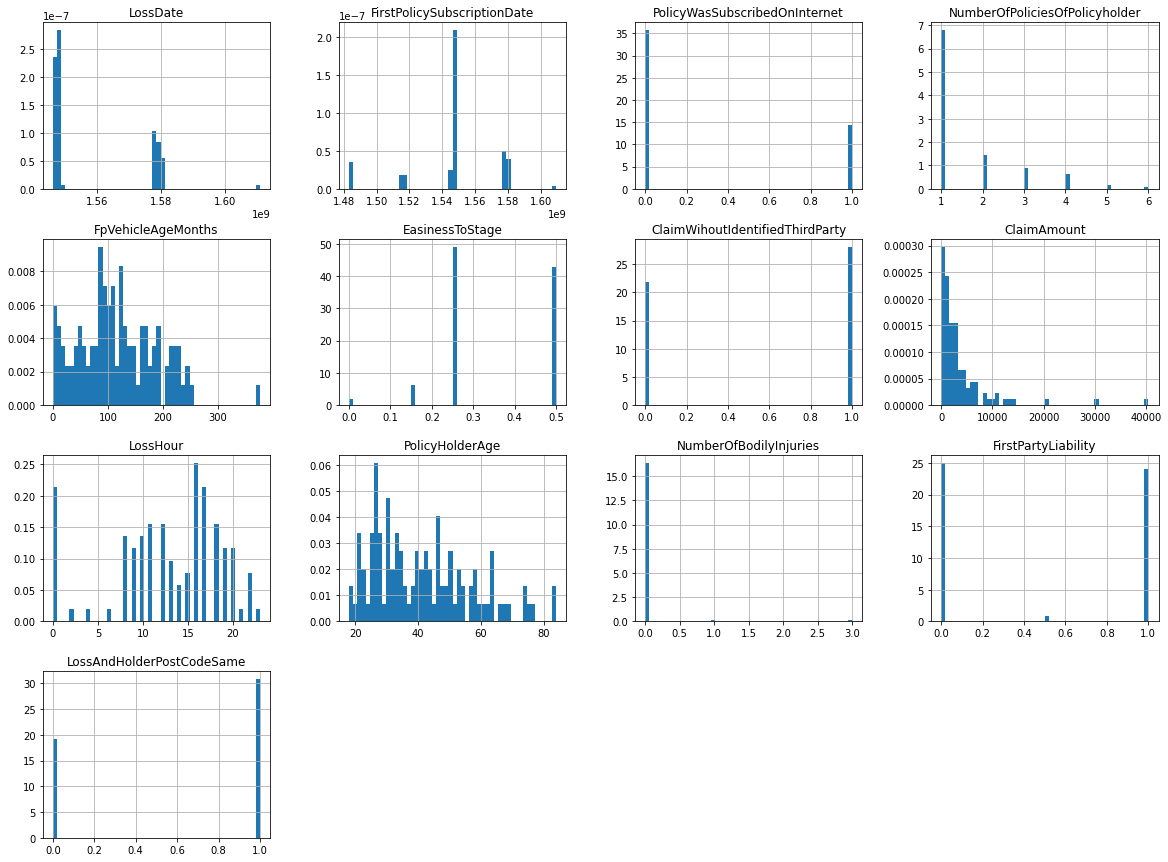

-----------------------------------------------------
The distribution numerical data of non-fraud datasets:


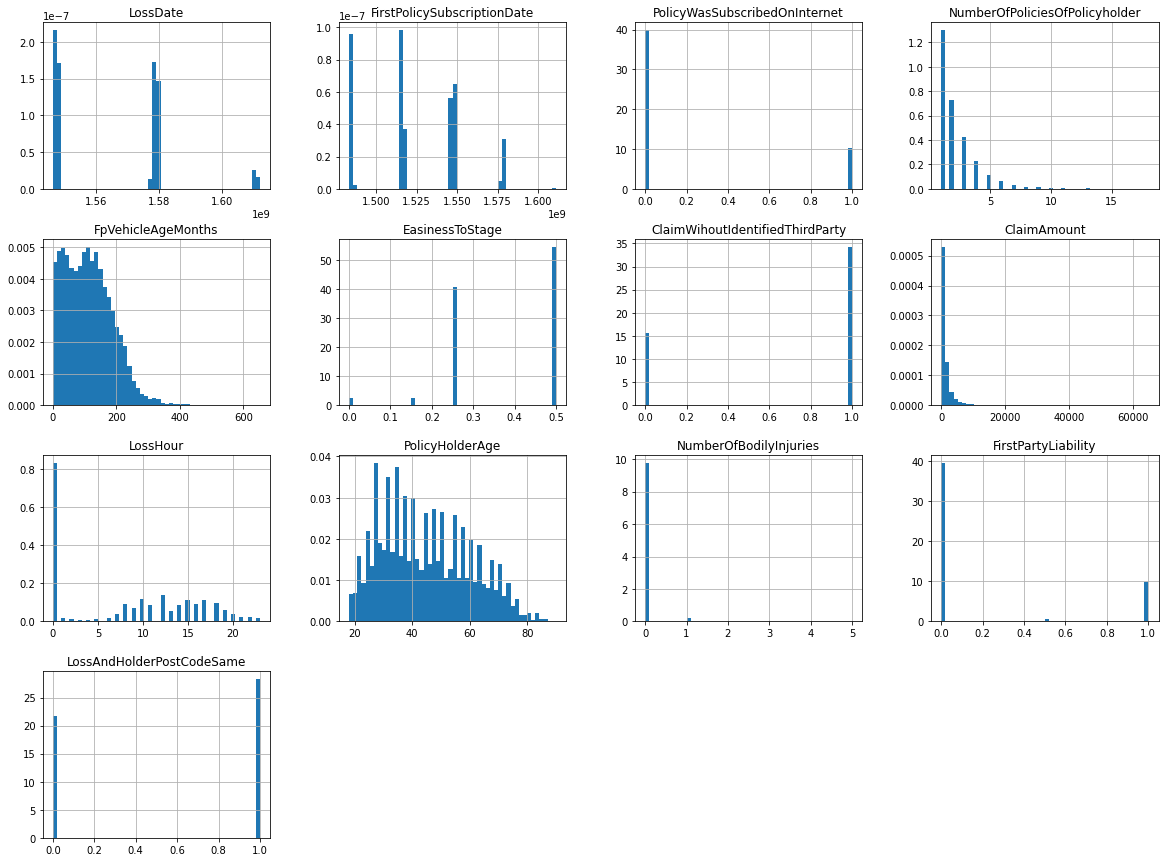

In [106]:
# plot the distribution of fraud datasets
print('The distribution numerical data of fraud datasets:')
df_fraud.iloc[:,:-1].hist(bins=50, figsize=(20,15),density=True, xlabelsize=10, ylabelsize=10)
plt.show()
print('-----------------------------------------------------')

# plot the distribution of non-fraud datasets
print('The distribution numerical data of non-fraud datasets:')
df_non_fraud.iloc[:,:-1].hist(bins=50, figsize=(20,15),density=True, xlabelsize=10, ylabelsize=10)
plt.show()

# TODO show the classification of categorical data


## 2.7 Clean features
1. deal with outliers 
    The presence of outliers in the data is a major problem for machine learning algorithms (Chakravarty, et al., 2020). 
    TODO: deal with outliers, or at the end to illustrate the lackness of the research
   
     
2. dummy variables

In [107]:
# Get dummy variables for categorical data
dummy_columns = ['PolicyholderOccupation', 'ClaimCause','ClaimInvolvedCovers', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']
# Dummy variables for categorical data
df = pd.get_dummies(df,columns=dummy_columns,drop_first=True)
df


,LossDate,FirstPolicySubscriptionDate,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,LossAndHolderPostCodeSame,Fraud,PolicyholderOccupation_Employee,PolicyholderOccupation_Executive,PolicyholderOccupation_Farmer,PolicyholderOccupation_HeadOfCompany,PolicyholderOccupation_Merchant,PolicyholderOccupation_NaN,PolicyholderOccupation_Retired,PolicyholderOccupation_SelfEmployed,PolicyholderOccupation_Student,PolicyholderOccupation_Unemployed,PolicyholderOccupation_Worker,ClaimCause_AccidentWithIdentifiedThirdParty,ClaimCause_AccidentWithUnidentifiedThirdParty,ClaimCause_CollisionWithAnimal,ClaimCause_CollisionWithPedestrian,ClaimCause_Fire,ClaimCause_Flood,ClaimCause_ForcesOfNature,ClaimCause_Hail,ClaimCause_LegalProtection,ClaimCause_LossOfControl,ClaimCause_MultiVehicleCrash,ClaimCause_NaN,ClaimCause_Storm,ClaimCause_TheftAttempt,ClaimCause_TheftOfExteriorElements,ClaimCause_TotalTheft,ClaimCause_Vandalism,ClaimCause_WindscreenDamage,ClaimInvolvedCovers_Accessories ActLiability Theft,ClaimInvolvedCovers_Accessories MaterialDamages ActLiability,ClaimInvolvedCovers_Accessories MaterialDamages ActLiability MedicalCare,ClaimInvolvedCovers_Accessories MaterialDamages ActLiability ThirdParty,ClaimInvolvedCovers_Accessories Theft,ClaimInvolvedCovers_Accessories Windscreen,ClaimInvolvedCovers_Accessories Windscreen ActLiability,ClaimInvolvedCovers_Accessories Windscreen ActLiability Burglary,ClaimInvolvedCovers_Accessories Windscreen ActLiability Theft,ClaimInvolvedCovers_Accessories Windscreen Theft,ClaimInvolvedCovers_ActLiability,ClaimInvolvedCovers_ActLiability Burglary,ClaimInvolvedCovers_ActLiability Burglary ReplacementVehicle,ClaimInvolvedCovers_ActLiability Burglary Theft,ClaimInvolvedCovers_ActLiability Burglary Theft ReplacementVehicle,ClaimInvolvedCovers_ActLiability Fire,ClaimInvolvedCovers_ActLiability Fire Burglary,ClaimInvolvedCovers_ActLiability Fire ReplacementVehicle,ClaimInvolvedCovers_ActLiability Fire ThirdParty,ClaimInvolvedCovers_ActLiability MaterialDamages,ClaimInvolvedCovers_ActLiability MedicalCare,ClaimInvolvedCovers_ActLiability MedicalCare ThirdParty,ClaimInvolvedCovers_ActLiability NaturalCatastrophes,ClaimInvolvedCovers_ActLiability NaturalCatastrophes Burglary,ClaimInvolvedCovers_ActLiability NaturalCatastrophes ReplacementVehicle,ClaimInvolvedCovers_ActLiability ReplacementVehicle,ClaimInvolvedCovers_ActLiability Theft,ClaimInvolvedCovers_ActLiability Theft ReplacementVehicle,ClaimInvolvedCovers_ActLiability ThirdParty,ClaimInvolvedCovers_ActLiability ThirdParty ReplacementVehicle,ClaimInvolvedCovers_ActLiability ThirdParty Theft,ClaimInvolvedCovers_Burglary,ClaimInvolvedCovers_Burglary Theft,ClaimInvolvedCovers_MaterialDamages,ClaimInvolvedCovers_MaterialDamages ActLiability,ClaimInvolvedCovers_MaterialDamages ActLiability Burglary,ClaimInvolvedCovers_MaterialDamages ActLiability Burglary ReplacementVehicle,ClaimInvolvedCovers_MaterialDamages ActLiability Fire,ClaimInvolvedCovers_MaterialDamages ActLiability MedicalCare,ClaimInvolvedCovers_MaterialDamages ActLiability MedicalCare ThirdParty,ClaimInvolvedCovers_MaterialDamages ActLiability NaturalCatastrophes,ClaimInvolvedCovers_MaterialDamages ActLiability NaturalCatastrophes ReplacementVehicle,ClaimInvolvedCovers_MaterialDamages ActLiability ReplacementVehicle,ClaimInvolvedCovers_MaterialDamages ActLiability Theft,ClaimInvolvedCovers_MaterialDamages ActLiability ThirdParty,ClaimInvolvedCovers_MaterialDamages ActLiability ThirdParty ReplacementVehicle,ClaimInvolvedCovers_MaterialDamages Burglary,ClaimInvolvedCovers_MaterialDamages ThirdParty,ClaimInvolvedCovers_MedicalCare,ClaimInvolvedCovers_MedicalCare ThirdParty,ClaimInvolvedCovers_NaN,ClaimInvolvedCovers_NaturalCatastrophes,ClaimInvolvedCovers_NaturalCatastrophes ActLiability ReplacementVehicle,ClaimInvolvedCovers_Theft,ClaimInvolvedCovers_ThirdParty,ClaimInvolvedCovers_

## 2.8 Split the data and scale
We are going to use MinMaxScaler in this case, since we can find the dataset not follow a Gaussian distribution. In addition, we will fit the MinMaxScaler model with trainning and validation dataset and apply the model to the test dataset to ensure we are blind to the data information before we test the data.
Here is the process of split and scale data:
1. Turn the dataframe into X and y array
1. Split the train and test
2. Fit the MinMaxScaler to train data and then apply the model to test data
3. Split the train data into train and validation data

In [116]:
# Turn the dataframe into X and y array
X = df.drop(['Fraud'],axis=1,inplace=False).to_numpy()
y = df[['Fraud']].to_numpy().flatten()
print('The shape of X:')
print(X.shape)
print('-----------------------------------------------------')
print('The shape of y:')
print(y.shape)
print('-----------------------------------------------------')

The shape of X:
(11371, 119)
-----------------------------------------------------
The shape of y:
(11371,)
-----------------------------------------------------


array([[1.57844208e+09, 1.51632012e+09, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.60963218e+09, 1.48426596e+09, 7.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.61015046e+09, 1.48538910e+09, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.57801008e+09, 1.57939230e+09, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.57999692e+09, 1.54785618e+09, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.57939254e+09, 1.48322886e+09, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [117]:
# Split the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=192,test_size=0.2)


In [119]:
# Fit the MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [123]:
# Split the train datasets into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,random_state=192,test_size=0.25)


In [127]:
## 2.9 Show the data structure of the data
print('-----------------------------------------------------')
print('Shape of X_train:')
print(X_train.shape)
print('-----------------------------------------------------')
print('Shape of y_train:')
print(y_train.shape)
print('-----------------------------------------------------')
print('Shape of X_val:')
print(X_val.shape)
print('-----------------------------------------------------')
print('Shape of y_val:')
print(y_val.shape)
print('-----------------------------------------------------')
print('Shape of X_test:')
print(X_test.shape)
print('-----------------------------------------------------')
print('Shape of y_test:')
print(y_test.shape)
print('-----------------------------------------------------')



-----------------------------------------------------
Shape of X_train:
(6822, 119)
-----------------------------------------------------
Shape of y_train:
(6822,)
-----------------------------------------------------
Shape of X_val:
(2274, 119)
-----------------------------------------------------
Shape of y_val:
(2274,)
-----------------------------------------------------
Shape of X_test:
(2275, 119)
-----------------------------------------------------
Shape of y_test:
(2275,)
-----------------------------------------------------


## Task 3
### Question
Start by creating a (deep) neural network in TensorFlow and train it on the data. Using training and validation sets, find a model with high accuracy, then evaluate it on the test set. In particular, record both the accuracy and AUC. Briefly discuss what issues you observe based on the metrics.


In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,roc_auc_score


In [ ]:
%load_ext tensorboard

In [ ]:
rm -rf ./logs/

In [ ]:
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.001,0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
# the number of units in the hidden layer, 1 time, 2 times or 3 times of the unit number of input layer
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete(range(X.shape[1], X.shape[1]+1,X.shape[1]))) 
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid']))
HP_HIDDEN_LAYER_NUMBER = hp.HParam('hidden_layer_number', hp.Discrete(range(1,6)))
METRIC_CROSSENTROPY = 'binary_crossentropy'
EPOCHS = 10

Once we have set up our parameters and metrics, we write those into our folder with the logs:

In [ ]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_LEARNING_RATE, HP_OPTIMIZER, HP_DROPOUT, HP_NUM_UNITS,HP_ACTIVATION,HP_HIDDEN_LAYER_NUMBER],
                      metrics = [hp.Metric(METRIC_CROSSENTROPY, display_name='CROSSENTROPY')])

In [ ]:
def train_model(hparams,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    # early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION])]*hparams[HP_HIDDEN_LAYER_NUMBER]+[
        tf.keras.layers.Dense(1,activation='sigmoid')])

    if hparams[HP_OPTIMIZER] == 'sgd':
        # Note that exploding gradients can be a big problem when running regressions, especially under SGD
        # Hence, we use "gradient clipping" with parameter alpha, which means that the gradients are manually kept between -1 and 1
        # This is of course another hyperparameter that we might tune!
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hparams[HP_LEARNING_RATE], clipvalue=1)
    elif hparams[HP_OPTIMIZER] == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hparams[HP_LEARNING_RATE])

    # random_seed = 192
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy')

    model.fit(X_train, y_train, epochs=EPOCHS)
    loss = model.evaluate(X_test, y_test)
    x_test_predict = model.predict(X_test)
    # calculate the roc
    roc_score = roc_auc_score(y_test, x_test_predict)
    # calculate the accuracy suppose the threshold is 0.5
    x_test_predict_binary = np.where(x_test_predict>0.5,1,0)
    accuracy = accuracy_score(y_test, x_test_predict_binary)
    # calculate the sensitivity
    sensitivity = recall_score(y_test, x_test_predict_binary)
    return loss, accuracy,roc_score,sensitivity


In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        loss, accuracy,roc_score,sensitivity = train_model(hparams)
        tf.summary.scalar('ACCUARY', accuracy, step=1)
        tf.summary.scalar('LOSS', loss, step=1)
        tf.summary.scalar('ROC', roc_score, step=1)
        tf.summary.scalar('SENSITIVITY', sensitivity, step=1)

In [ ]:
total_sessions = 3 #FIXME: change this to the number of sessions you want to run, and fix the issue in the metrics

for session in range(total_sessions):
    
    # Create hyperparameters randomly
    dropout_rate = HP_DROPOUT.domain.sample_uniform()
    num_units = HP_NUM_UNITS.domain.sample_uniform()
    optimizer = HP_OPTIMIZER.domain.sample_uniform()
    activation = HP_ACTIVATION.domain.sample_uniform()
    hidden_layer_number = HP_HIDDEN_LAYER_NUMBER.domain.sample_uniform()
    
    r = -3*np.random.rand()
    learning_rate = 10.0**r
    
    # Create a dictionary of hyperparameters
    hparams = { HP_LEARNING_RATE: learning_rate,
                HP_OPTIMIZER: optimizer,
                HP_DROPOUT: dropout_rate,
                HP_NUM_UNITS: num_units,
                HP_ACTIVATION: activation,
                HP_HIDDEN_LAYER_NUMBER: hidden_layer_number}
    
    # train the model with the chosen parameters
    run_name = "run-%d" % session
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)

In [ ]:
%tensorboard --logdir logs

## Task 4
### Question
Start by creating a (deep) neural network in TensorFlow and train it on the data. Using training and validation sets, find a model with high accuracy, then evaluate it on the test set. In particular, record both the accuracy and AUC. Briefly discuss what issues you observe based on the metrics.

### Principle
In this part, we are going to try both oversampling and undersampling.


In [ ]:
# TODO draw the plot after resampling the data
import imblearn
from collections import Counter
import matplotlib.pyplot as plt

### Oversampling
We will successively try to oversample the minority class to 10%, 30%,50% of the size of all datasets.

In [ ]:
# k_neighbors set to 20 to make sure that the result is more general 
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state = 483, k_neighbors=20)  
X_over_synth_10, y_over_synth_10 = over.fit_resample(X_train, y_train)
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.5, random_state = 483, k_neighbors=20)
X_over_synth_30, y_over_synth_30 = over.fit_resample(X_train, y_train)
over = imblearn.over_sampling.SMOTE(sampling_strategy=1, random_state = 483, k_neighbors=20)
X_over_synth_50, y_over_synth_50 = over.fit_resample(X_train, y_train)

In [ ]:
print("Percentage of 1 in y_over_synth10:", Counter(y_over_synth_10)[1]/len(y_over_synth_10))
print("Percentage of 1 in y_over_synth30:", Counter(y_over_synth_30)[1]/len(y_over_synth_30))
print("Percentage of 1 in y_over_synth50:", Counter(y_over_synth_50)[1]/len(y_over_synth_50))

### Undersampling
We will successively try to undersample the minority class to 10%, 30%,50% of the size of majority class.

In [ ]:
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.1, random_state = 483)  
X_under_synth_10, y_under_synth_10 = under.fit_resample(X_train, y_train)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state = 483)
X_under_synth_30, y_under_synth_30 = under.fit_resample(X_train, y_train)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = 483)
X_under_synth_50, y_under_synth_50 = under.fit_resample(X_train, y_train)

In [ ]:
print("Percentage of 1 in y_under_synth_10:", Counter(y_under_synth_10)[1]/len(y_under_synth_10))
print("Percentage of 1 in y_under_synth_30:", Counter(y_under_synth_30)[1]/len(y_under_synth_30))
print("Percentage of 1 in y_under_synth_50:", Counter(y_under_synth_50)[1]/len(y_under_synth_50))

## Task 5
### Question
 Create a new (deep) neural network and train it on your enhanced dataset. Use training and validation sets derived from the enhanced dataset to find a model with high accuracy. Evaluate your final model on a test set consisting only of original data. Again, record the accuracy and AUC. Briefly discuss the changes you would expect in the metrics and the actual changes you observe. Would you say that you are now doing better at identifying fraudulent claims?

### Principle
To simplify the problem, and save computational time, we will apply all the synthetic data to a very simple neural network, and then compare the performance of these dinstinct synthetic data.
The neural network structure is as follows:
1. Input layer
2. 2 Hiiden layers, in which the number of neurons in each layer is equal to input layer and 'relu' activation function is used.
3. No dropout layer
4. Output layer, with 'sigmoid' activation function.
5. Optimizer: AdamOptimizer

In [ ]:
class TrainModel:
    def __init__(self, X_train, y_train, X_test= X_test, y_test=y_test,epochs=100,early_stopping_cb:bool=False,patience:int=10):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.epochs = epochs
        self.early_stopping_cb = early_stopping_cb
        self.patience = patience
        self.simple_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(X_train.shape[1], activation=activation, input_shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(X_train.shape[1], activation='relu'),
            tf.keras.layers.Dense(X_train.shape[1], activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def compile(self):
        self.simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def fit(self):
        if self.early_stopping_cb:
            early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=self.patience, restore_best_weights=True) # set patience to 10 to accelerate the training
            self.simple_model.fit(self.X_train, self.y_train,validation_data= (X_test, y_test),callbacks=[early_stopping_cb])
        else:
            self.simple_model.fit(self.X_train, self.y_train,validation_data= (X_test, y_test),epochs=EPOCHS)

    def evaluate(self):
        loss = self.simple_model.evaluate(X_test, y_test)
        x_test_predict = self.simple_model.predict(X_test)
        # calculate the roc
        roc_score = roc_auc_score(y_test, x_test_predict)
        # calculate the accuracy suppose the threshold is 0.5
        x_test_predict_binary = np.where(x_test_predict>0.5,1,0)
        accuracy = accuracy_score(y_test, x_test_predict_binary)
        # calculate the sensitivity
        sensitivity = recall_score(y_test, x_test_predict_binary)
        return {'loss': loss, 'accuracy': accuracy, 'sensitivity': sensitivity, 'roc': roc_score}

    def run(self):
        self.compile()
        self.fit()
        return self.evaluate()
    


In [ ]:
res_list = [] # FIXME
for X_train,y_train in zip([X_over_synth_10,X_over_synth_30,X_over_synth_50,X_under_synth_10,X_under_synth_30,X_under_synth_50], [y_over_synth_10,y_over_synth_30,y_over_synth_50,y_under_synth_10,y_under_synth_30,y_under_synth_50]):
    tm = TrainModel(X_train,y_train,early_stopping_cb=True)
    res = tm.run()
    res_list.append(res)

In [ ]:
res_list